##### Copyright 2020 The TensorFlow Authors.

In [1]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [2]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units1: int,
      num_hidden_units2: int):
    """Initialize."""
    super().__init__()

    self.common2 = layers.Dense(num_hidden_units2, activation="relu")
    self.common1 = layers.Dense(num_hidden_units1, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common1(inputs)
    y = self.common2(x)
    return self.actor(y), self.critic(y)

In [3]:
num_actions = env.action_space.n  # 2
num_hidden_units1 = 72
num_hidden_units2 = 36

model = ActorCritic(num_actions, num_hidden_units1,num_hidden_units2)
model.save_weights('model.h2')

In [4]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [5]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

In [6]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

In [7]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

In [17]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

# rewards
rewards = []

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    rewards.append(episode_reward)
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    # if running_reward > reward_threshold and i >= min_episodes_criterion:  
    #     break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/10000 [00:02<?, ?it/s]


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mul/Mul_1' defined at (most recent call last):
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 359, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Vedant\AppData\Local\Temp\ipykernel_19980\1007850009.py", line 1, in <module>
      get_ipython().run_cell_magic('time', '', "\nmin_episodes_criterion = 100\nmax_episodes = 10000\nmax_steps_per_episode = 1000\n\n# Cartpole-v0 is considered solved if average reward is >= 195 over 100 \n# consecutive trials\nreward_threshold = 195\nrunning_reward = 0\n\n# Discount factor for future rewards\ngamma = 0.99\n\n# Keep last episodes reward\nepisodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)\n\n# rewards\nrewards = []\n\nwith tqdm.trange(max_episodes) as t:\n  for i in t:\n    initial_state = tf.constant(env.reset(), dtype=tf.float32)\n    episode_reward = int(train_step(\n        initial_state, model, optimizer, gamma, max_steps_per_episode))\n    \n    rewards.append(episode_reward)\n    \n    episodes_reward.append(episode_reward)\n    running_reward = statistics.mean(episodes_reward)\n  \n    t.set_description(f'Episode {i}')\n    t.set_postfix(\n        episode_reward=episode_reward, running_reward=running_reward)\n  \n    # Show average episode reward every 10 episodes\n    if i % 10 == 0:\n      pass # print(f'Episode {i}: average reward: {avg_reward}')\n  \n    # if running_reward > reward_threshold and i >= min_episodes_criterion:  \n    #     break\n\nprint(f'\\nSolved at episode {i}: average reward: {running_reward:.2f}!')\n")
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2257, in run_cell_magic
      result = fn(*args, **kwargs)
    File "C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\execution.py", line 1316, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 22, in <module>
    File "C:\Users\Vedant\AppData\Local\Temp\ipykernel_19980\892927516.py", line 30, in train_step
      grads = tape.gradient(loss, model.trainable_variables)
Node: 'gradient_tape/mul/Mul_1'
Incompatible shapes: [46,1] vs. [4,1]
	 [[{{node gradient_tape/mul/Mul_1}}]] [Op:__inference_train_step_2249]

In [9]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 475
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

def actor_critic():

  model.load_weights('model.h2')
  # Keep last episodes reward
  episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

  # rewards
  rewards = []

  with tqdm.trange(max_episodes) as t:
    for i in t:
      initial_state = tf.constant(env.reset(), dtype=tf.float32)
      episode_reward = int(train_step(
          initial_state, model, optimizer, gamma, max_steps_per_episode))
      
      rewards.append(episode_reward)
      
      episodes_reward.append(episode_reward)
      running_reward = statistics.mean(episodes_reward)
    
      t.set_description(f'Episode {i}')
      t.set_postfix(
          episode_reward=episode_reward, running_reward=running_reward)
    
      # Show average episode reward every 10 episodes
      if i % 10 == 0:
        pass # print(f'Episode {i}: average reward: {avg_reward}')
    
      # if running_reward > reward_threshold and i >= min_episodes_criterion:  
      #     break

  print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')
  return rewards

accumator = []
for _ in range(10):
  rewards = actor_critic()
  accumator.append(rewards)
  


Episode 9999: 100%|██████████| 10000/10000 [15:16<00:00, 10.91it/s, episode_reward=322, running_reward=487]



Solved at episode 9999: average reward: 486.84!


Episode 9004:  90%|█████████ | 9005/10000 [25:17<02:47,  5.93it/s, episode_reward=500, running_reward=492]   


KeyboardInterrupt: 

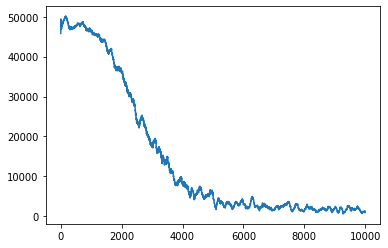

In [16]:
variance = np.var(accumator, axis=0)
avg_plot = []
for i in range(len(variance)):
    if(i >= 10):
        avg_plot.append(np.mean(variance[i-10:i+1]))
    else:
        avg_plot.append(np.mean(variance[0:i+1]))
    # rewards[i] = avg_plot[i]
plt.plot(avg_plot)

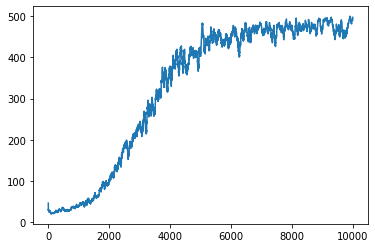

In [11]:
import matplotlib.pyplot as plt
rewards = np.mean(accumator, axis=0)
avg_plot = []
for i in range(len(rewards)):
    if(i >= 50):
        avg_plot.append(np.mean(rewards[i-50:i+1]))
    else:
        avg_plot.append(np.mean(rewards[0:i+1]))
    # rewards[i] = avg_plot[i]
plt.plot(avg_plot)

In [ ]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

FileNotFoundError: [WinError 2] The system cannot find the file specified


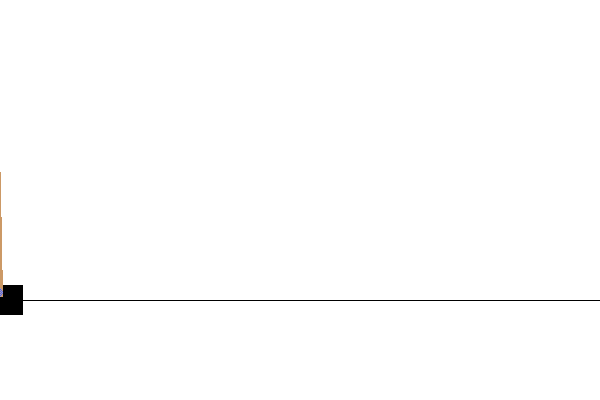

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## Next steps

This tutorial demonstrated how to implement the actor-critic method using Tensorflow.

As a next step, you could try training a model on a different environment in OpenAI Gym. 

For additional information regarding actor-critic methods and the Cartpole-v0 problem, you may refer to the following resources:

- [Actor Critic Method](https://hal.inria.fr/hal-00840470/document)
- [Actor Critic Lecture (CAL)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cartpole learning control problem \[Barto, et al. 1983\]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) 

For more reinforcement learning examples in TensorFlow, you can check the following resources:
- [Reinforcement learning code examples (keras.io)](https://keras.io/examples/rl/)
- [TF-Agents reinforcement learning library](https://www.tensorflow.org/agents)
